In [29]:

import numpy as np 
import pandas as pd 
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf 
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input 



In [30]:
BASE_DIR = 'archive/UTKFace'

In [31]:
# labels, gender, age
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    

  0%|          | 0/23708 [00:00<?, ?it/s]

In [32]:
# convert to dataframe 
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,archive/UTKFace/26_0_4_20170117195915493.jpg.c...,26,0
1,archive/UTKFace/23_0_0_20170117144406947.jpg.c...,23,0
2,archive/UTKFace/25_0_3_20170119171616945.jpg.c...,25,0
3,archive/UTKFace/50_0_0_20170117185805681.jpg.c...,50,0
4,archive/UTKFace/28_1_4_20170103225940625.jpg.c...,28,1


In [33]:
# map labels for gender
gender_dict = { 0: 'Male', 1: 'Female'}


## Explory Data Analysis

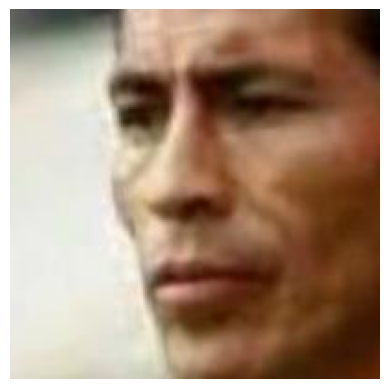

In [34]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

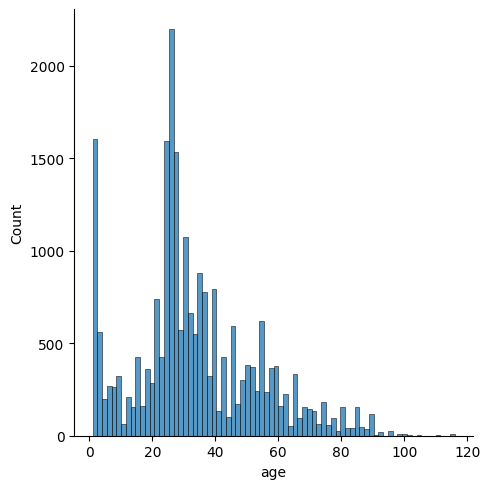

In [35]:
sns.displot(df['age'])

<Axes: ylabel='count'>

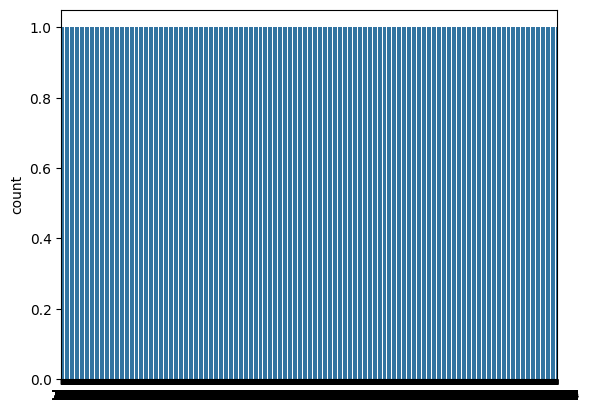

In [36]:
sns.countplot(df['gender'])

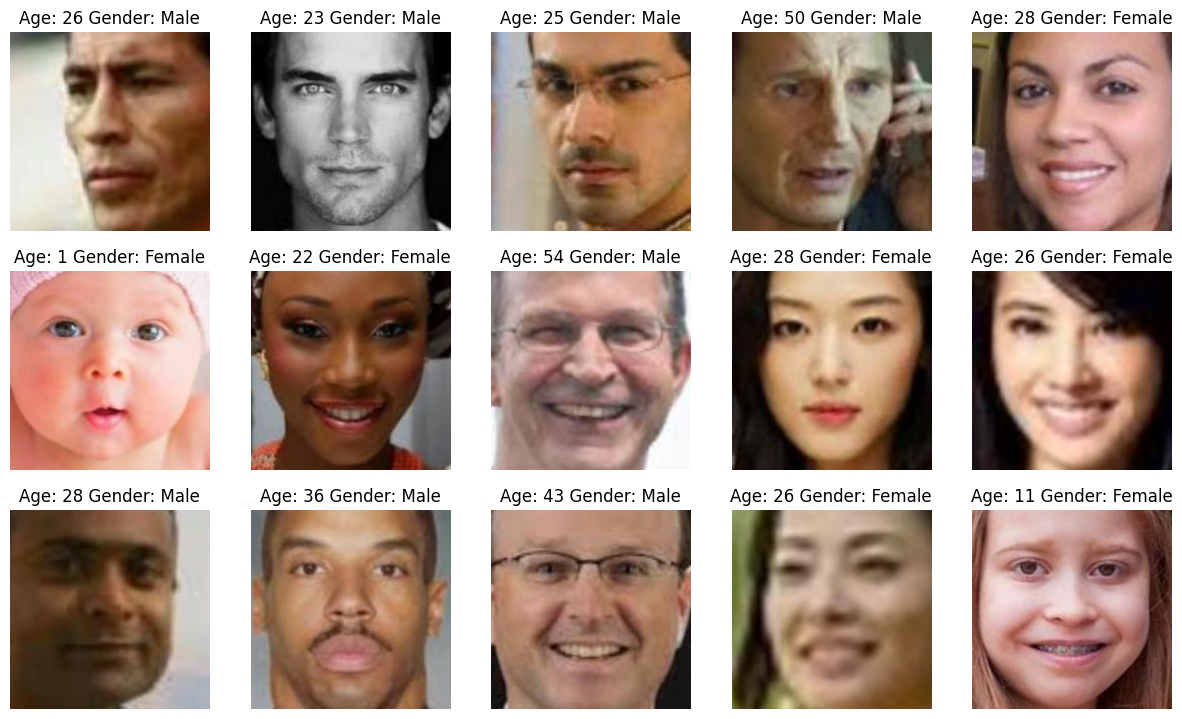

In [37]:
# to dislpaay grid of images
plt.figure(figsize=(15,15))
files = df.iloc[0:15]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')
    

## Feature Extraction

In [38]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L') 
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [39]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [40]:
X.shape

(23708, 128, 128, 1)

In [41]:
X = X/255.0

In [42]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [43]:
input_shape = (128, 128, 1)

## Model Creation

In [44]:
inputs = Input((input_shape))
## convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])


In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [48]:

# Train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 421s 709ms/step - loss: 11.3799 - gender_out_loss: 0.4869 - age_out_loss: 10.8930 - gender_out_accuracy: 0.7670 - gender_out_mae: 0.3242 - age_out_accuracy: 0.0431 - age_out_mae: 10.8930 - val_loss: 10.2629 - val_gender_out_loss: 0.4391 - val_age_out_loss: 9.8239 - val_gender_out_accuracy: 0.7914 - val_gender_out_mae: 0.3027 - val_age_out_accuracy: 0.0481 - val_age_out_mae: 9.8239
Epoch 2/30
593/593 [==============================] - 410s 691ms/step - loss: 9.5875 - gender_out_loss: 0.4015 - age_out_loss: 9.1861 - gender_out_accuracy: 0.8149 - gender_out_mae: 0.2628 - age_out_accuracy: 0.0443 - age_out_mae: 9.1861 - val_loss: 8.7023 - val_gender_out_loss: 0.3511 - val_age_out_loss: 8.3512 - val_gender_out_accuracy: 0.8402 - val_gender_out_mae: 0.2192 - val_age_out_accuracy: 0.0481 - val_age_out_mae: 8.3512
Epoch 3/30
593/593 [==============================] - 441s 744ms/step - loss: 8.6858 - gender_out_loss: 0.3544 - age_out_loss: 8

## Plot the Results

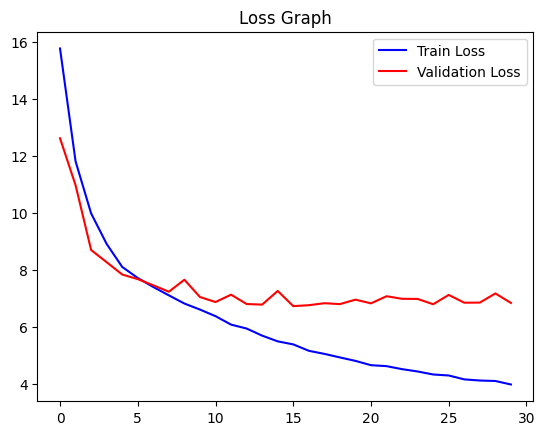

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

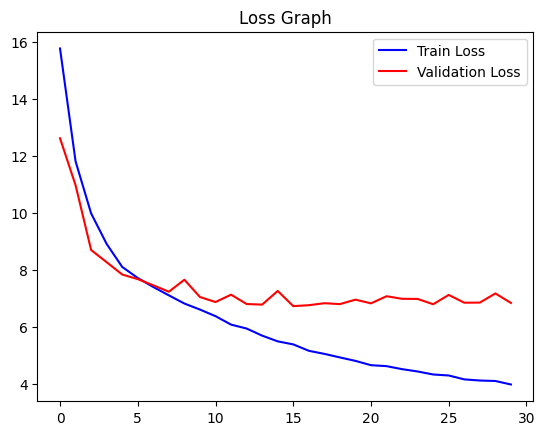

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data


Original Gender:  Female Original Age:  1
1/1 [==============================] - 0s 49ms/step
Predict Gender:  Female Predicted Age:  1


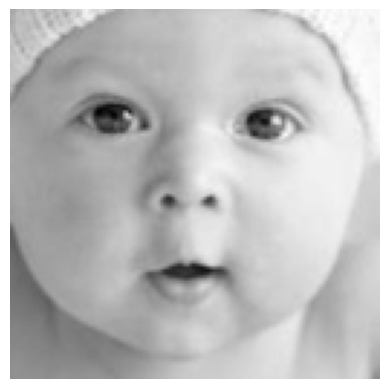

In [51]:
image_index = 5
print('Original Gender: ', gender_dict[y_gender[image_index]], 'Original Age: ', y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print('Predict Gender: ', pred_gender, 'Predicted Age: ', pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

In [52]:
model.save('meu_modelo')

INFO:tensorflow:Assets written to: meu_modelo/assets


INFO:tensorflow:Assets written to: meu_modelo/assets


In [53]:
model = tf.keras.models.load_model('meu_modelo')


Original Gender:  Male Original Age:  28
1/1 [==============================] - 0s 40ms/step
Predict Gender:  Male Predicted Age:  32


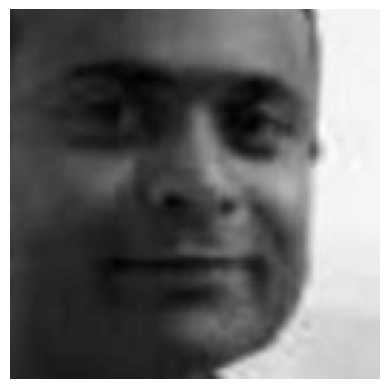

In [55]:
image_index = 10
print('Original Gender: ', gender_dict[y_gender[image_index]], 'Original Age: ', y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

pred_gender = gender_dict[round(pred[0][0][0])]

pred_age = round(pred[1][0][0])

print('Predict Gender: ', pred_gender, 'Predicted Age: ', pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')